### importing libraries:

In [81]:
from collections import Counter
import csv
import re
import pandas as pd
import numpy as np

from sklearn.model_selection import ParameterGrid
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression

import matplotlib as plt
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import emoji
import string

import nltk
from nltk.tokenize import TweetTokenizer
from  nltk.stem.snowball import EnglishStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Faeze\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Faeze\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### reading data

In [63]:
data_dev = pd.read_csv("development.csv")
data_dev.drop(columns=['date', 'flag', 'user','ids'] , inplace = True)
data_ev = pd.read_csv("evaluation.csv")
data_ev.drop(columns=['date', 'flag', 'user','ids'] , inplace = True)

In [64]:
data_dev

,sentiment,text
0,1,"@MissBianca76 Yes, talking helps a lot.. going..."
1,1,SUNSHINE. livingg itttt. imma lie on the grass...
2,1,@PleaseBeMine Something for your iphone
3,0,@GabrielSaporta couldn't get in to the after p...
4,0,@bradiewebbstack awww is andy being mean again...
...,...,...
224989,0,@Dropsofreign yeah I hope Iran people reach fr...
224990,1,Trying the qwerty keypad
224991,0,I love Jasper &amp; Jackson but that wig in th...
224992,0,I am really tired and bored and bleh! I feel c...


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


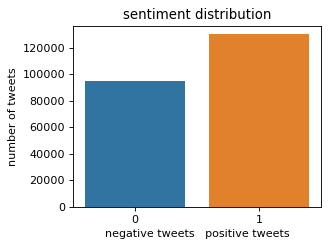

In [73]:

classes = set(data_dev['sentiment'])
classesfig, ax = plt.subplots(figsize=(4, 3), dpi=80)
ax = sns.countplot(data_dev['sentiment'])
ax.set_title("sentiment distribution")
plt.xlabel('negative tweets   positive tweets')
plt.ylabel('number of tweets')
plt.show()

In [75]:
data_dev['len'] = data_dev['text'].str.len()
pct95 = int(np.ceil(data_dev['len'].quantile(.95)))
pct50 = int(np.ceil(data_dev['len'].quantile(.5)))

print(f"50th percentile: {pct50}, 95th percentile: {pct95}")

50th percentile: 74, 95th percentile: 136


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


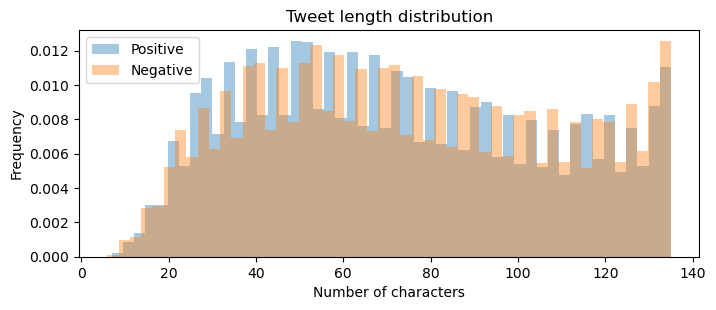

In [76]:
fig, ax = plt.subplots(figsize=(8, 3), dpi=100)
ax = sns.distplot(data_dev['len'].loc[(data_dev['sentiment'] == 1) & (data_dev['len'] < pct95)], bins=50, norm_hist=True, kde=False, label="Positive")
ax = sns.distplot(data_dev['len'].loc[(data_dev['sentiment'] == 0) & (data_dev['len'] < pct95)], bins=50, norm_hist=True, kde=False, label="Negative")
ax.set_title("Tweet length distribution")
plt.xlabel("Number of characters")
plt.ylabel("Frequency")
ax.legend()
plt.show()

In [66]:
n_null = data_dev.isnull().sum().sum()
n_empty = data_dev[data_dev['text'] == ""].shape[0]

print(f"Missing values: {n_null}")
print(f"Number of empty reviews: {n_empty}")

Missing values: 0
Number of empty reviews: 0


In [68]:
emoticon_chars = ["❤️", "😠", "😭","😔","😑","T_T",":*","-_-",":\)", ":\("]
count = 0
for c in emoticon_chars:
    c_count = data_dev['text'].str.contains(c).sum()
    if c_count > 0:
        count += c_count

count

225076

## data preprocessing

In [3]:
dict_emot = {
    ':)': "happy",
    ':(' : "sad" , 
    '^_^' : "happy",
    '-__-' : "angry",
    "-_-" : "angry",
    ":*" : "happy",
    "T_T" : "sad"
}

def emoji_detection(text):
    for e in dict_emot:

        if e in text.split():
            text = text.replace(e,dict_emot[e],1)
    for t in text.split():
        emojis = emoji.emoji_lis(t) # Handle Unicode emojis
        if len(emojis) > 0:
            for e in emojis:
                text = text.replace(t,emoji.demojize(e['emoji']),1)
            #     for e in emojis:
    return text


In [7]:
stop_words = set(stopwords.words("english")) - {'no'}|{'not'}|{'nor'}|{'neither'}
stemmer = EnglishStemmer()
def clean_text(text):
    output_str_lower =re.sub('[A-Z]+', lambda m: m.group(0).lower(), text) # lowercase
    output_noss = ' '.join(w for w in output_str_lower.split() if w not in stop_words) #
    output_nourl = re.sub(r'http\S+', '', output_noss)
    output_nousername = re.sub(r'@[^\s]+[\s]?', '', output_nourl)
    output_nospecialcharacter = re.sub("[^-9A-Za-z ]", "" , output_nousername)
    output_nonumber = re.sub(r'\s?[0-9]+\.?[0-9]*','', output_nospecialcharacter)
    output_stemming = [stemmer.stem(i) for i in output_nonumber.split()]
    output_stemming = ' '.join(output_stemming)
    return output_stemming

# test cleaning
print(clean_text("sarina is @faezeh walked this 456 #kd%"))

sarina walk kd


In [5]:
def tokenize_ours(text):
    tweet = TweetTokenizer()
    output_tokenized=tweet.tokenize(text)
    return output_tokenized

### data cleaning

In [8]:
# data cleaning
data_dev['text'] = data_dev['text'].map(lambda x: emoji_detection(x)) 
data_dev['text'] = data_dev['text'].map(lambda x: clean_text(x)) 
data_ev['text'] = data_ev['text'].map(lambda x: emoji_detection(x)) 
data_ev['text'] = data_ev['text'].map(lambda x: clean_text(x)) 

### vectorizing data

In [10]:
vectorizer_unbounded = TfidfVectorizer(input='content', tokenizer=tokenize_ours, min_df=2, ngram_range=(1,2))
X = vectorizer_unbounded.fit_transform(data_dev['text'])
print(X.shape)

(224994, 166793)


In [54]:
#we set max features to 10000 to avoid overfitting
vectorizer = TfidfVectorizer(input='content', tokenizer=tokenize_ours, min_df=2, ngram_range=(1,2) ,max_features=10000)
X = vectorizer.fit_transform(data_dev['text'])
print(X.shape)

(224994, 10000)


In [12]:
y = data_dev['sentiment']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Nayive Bayes:

In [37]:
clf = MultinomialNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.7619    0.6499    0.7015     19068
           1     0.7677    0.8507    0.8071     25931

    accuracy                         0.7656     44999
   macro avg     0.7648    0.7503    0.7543     44999
weighted avg     0.7653    0.7656    0.7623     44999



In [18]:
params = {
    'alpha': np.arange(0.1,2,0.1)
}

# print(params['gamma'])

model = MultinomialNB()
clf = GridSearchCV(model, param_grid=params, scoring='f1_weighted', cv=3, n_jobs=4,verbose=10 )
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, digits=4))

Fitting 3 folds for each of 19 candidates, totalling 57 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done  57 out of  57 | elapsed:    2.7s finished


              precision    recall  f1-score   support

           0     0.7656    0.6452    0.7003     19068
           1     0.7662    0.8548    0.8080     25931

    accuracy                         0.7660     44999
   macro avg     0.7659    0.7500    0.7542     44999
weighted avg     0.7659    0.7660    0.7624     44999



In [15]:
clf.best_params_

{'alpha': 1.1}

In [20]:
import matplotlib.pyplot as plt



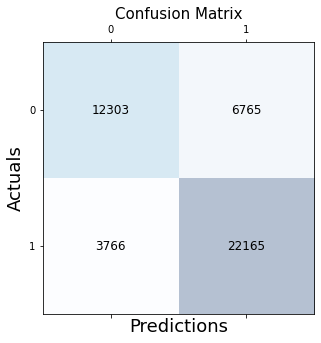

In [25]:
# Calculate the confusion matrix
#
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=15)
plt.show()

#### SVM:

In [26]:
params = {
    'C': [1,10,100,1000]
}

# print(params['gamma'])

svc = svm.LinearSVC(tol=1e-9, dual=False, intercept_scaling=0.001, loss="squared_hinge", max_iter=10000, random_state=1, class_weight='balanced')

clf = GridSearchCV(svc, param_grid=params, scoring='f1_weighted', cv=3, n_jobs=4,verbose=10 )
clf.fit(X_train, y_train)

Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   8 | elapsed:    3.7s remaining:   11.4s
[Parallel(n_jobs=4)]: Done   3 out of   8 | elapsed:   30.1s remaining:   50.2s
[Parallel(n_jobs=4)]: Done   4 out of   8 | elapsed:   34.6s remaining:   34.6s
[Parallel(n_jobs=4)]: Done   5 out of   8 | elapsed:  4.3min remaining:  2.6min
[Parallel(n_jobs=4)]: Done   6 out of   8 | elapsed:  5.1min remaining:  1.7min
[Parallel(n_jobs=4)]: Done   8 out of   8 | elapsed:  9.5min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   8 out of   8 | elapsed:  9.5min finished


GridSearchCV(cv=2,
             estimator=LinearSVC(class_weight='balanced', dual=False,
                                 intercept_scaling=0.001, max_iter=10000,
                                 random_state=1, tol=1e-09),
             n_jobs=4, param_grid={'C': [1, 10, 100, 1000]},
             scoring='f1_weighted', verbose=10)

In [27]:
clf.best_score_

0.7565095450612722

In [28]:
clf.best_params_

{'C': 1}

In [44]:
model = svm.LinearSVC(C=1, tol=1e-9, dual=False, intercept_scaling=0.001, loss="squared_hinge", max_iter=10000, random_state=1, class_weight='balanced') 
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
score = f1_score(y_test, y_pred, average='weighted')

In [45]:
score

0.7679792912201788

In [48]:
model = svm.LinearSVC(C=0.9, tol=1e-9, dual=False, intercept_scaling=0.001, loss="squared_hinge", max_iter=10000, random_state=1, class_weight='balanced') 
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
score = f1_score(y_test, y_pred, average='weighted')

In [49]:
score

0.7681725266127436

In [32]:
    model = svm.LinearSVC(C=1.3, tol=1e-9, dual=False, intercept_scaling=0.001, loss="squared_hinge", max_iter=10000, random_state=1, class_weight='balanced') 
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = f1_score(y_test, y_pred, average='weighted')

In [33]:
print(score)

0.7696679733850028


In [50]:
params = {
  "min_df": [1, 2, 3, 4], 
  "max_df": [0.3, 0.35, 0.4, 0.45, 0.5, 0.55],
  "ngram_range": [(1,1), (1,2), (1,3)]
}

max_acc = 0
best_config = 0
j = 0
for config in ParameterGrid(params):
    pipe = Pipeline([('count', CountVectorizer(**config,  token_pattern=r'\b[^\d\W]+\b' )), ('tfid', TfidfTransformer())])
    vectors = pipe.fit_transform(data_dev.text) 
    X = vectors
    y = data_dev['sentiment']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = svm.LinearSVC(C=1.3, tol=1e-9, dual=False, intercept_scaling=0.001, loss="squared_hinge", max_iter=10000, random_state=1, class_weight='balanced')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = f1_score(y_test, y_pred, average='weighted')
#     print("Model configuration n.", j)
#     print("Parameter", config)
#     print("F1 score: ", score)
    if score > max_acc:
      max_acc = score
      best_config = config
    j += 1

In [39]:
print(max_acc)
print(best_config)

0.7741404522705367
{'max_df': 0.3, 'min_df': 1, 'ngram_range': (1, 3)}


In [41]:
pipe = Pipeline([('count', CountVectorizer(max_df= 0.3, min_df= 1, ngram_range= (1, 3),  token_pattern=r'\b[^\d\W]+\b' )), ('tfid', TfidfTransformer())])
X = pipe.fit_transform(data_dev.text)
y = data_dev['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = svm.LinearSVC(C=1.3, tol=1e-9, dual=False, intercept_scaling=0.001, loss="squared_hinge", max_iter=10000, random_state=1, class_weight='balanced') 
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.7465    0.7100    0.7278     19068
           1     0.7942    0.8227    0.8082     25931

    accuracy                         0.7750     44999
   macro avg     0.7704    0.7664    0.7680     44999
weighted avg     0.7740    0.7750    0.7741     44999



#### Logistic Regression:

In [57]:
params = {
    'C': [1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2]
}

# print(params['gamma'])

# svc = svm.LinearSVC(tol=1e-9, dual=False, intercept_scaling=0.001, loss="squared_hinge", max_iter=10000, random_state=1, class_weight='balanced')

clf = GridSearchCV(LogisticRegression(penalty='l1',solver='liblinear', max_iter = 10000), param_grid=params, scoring='f1_weighted', cv=3, n_jobs=4,verbose=10 )
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, digits=4))

Fitting 3 folds for each of 11 candidates, totalling 33 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    6.9s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   10.8s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   18.5s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   26.2s
[Parallel(n_jobs=4)]: Done  30 out of  33 | elapsed:   31.8s remaining:    3.1s
[Parallel(n_jobs=4)]: Done  33 out of  33 | elapsed:   34.0s finished


              precision    recall  f1-score   support

           0     0.7733    0.6802    0.7238     19068
           1     0.7840    0.8534    0.8172     25931

    accuracy                         0.7800     44999
   macro avg     0.7786    0.7668    0.7705     44999
weighted avg     0.7795    0.7800    0.7776     44999



In [58]:
clf.best_params_

{'C': 1.5}

In [15]:
params = {
  "min_df": [1, 2, 3, 4], 
  "max_df": [0.3, 0.35, 0.4, 0.45, 0.5, 0.55],
  "ngram_range": [(1,1), (1,2), (1,3)]
}

max_acc = 0
best_config = 0
j = 0
for config in ParameterGrid(params):
    pipe = Pipeline([('count', CountVectorizer(**config,  token_pattern=r'\b[^\d\W]+\b' )), ('tfid', TfidfTransformer())])
    vectors = pipe.fit_transform(data_dev.text) 
    X = vectors
    y = data_dev['sentiment']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = LogisticRegression(penalty='l1',solver='liblinear', max_iter = 10000 , C=1.5) 
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = f1_score(y_test, y_pred, average='weighted')
    print("Model configuration n.", j)
    print("Parameter", config)
    print("F1 score: ", score)
    if score > max_acc:
      max_acc = score
      best_config = config
    j += 1

Model configuration n. 0
Parameter {'max_df': 0.3, 'min_df': 1, 'ngram_range': (1, 1)}
F1 score:  0.7700776108338757
Model configuration n. 1
Parameter {'max_df': 0.3, 'min_df': 1, 'ngram_range': (1, 2)}
F1 score:  0.7779735620536427
Model configuration n. 2
Parameter {'max_df': 0.3, 'min_df': 1, 'ngram_range': (1, 3)}
F1 score:  0.7749891584603001
Model configuration n. 3
Parameter {'max_df': 0.3, 'min_df': 2, 'ngram_range': (1, 1)}
F1 score:  0.7704076962790574
Model configuration n. 4
Parameter {'max_df': 0.3, 'min_df': 2, 'ngram_range': (1, 2)}
F1 score:  0.7789144706632518
Model configuration n. 5
Parameter {'max_df': 0.3, 'min_df': 2, 'ngram_range': (1, 3)}
F1 score:  0.7785390935356808
Model configuration n. 6
Parameter {'max_df': 0.3, 'min_df': 3, 'ngram_range': (1, 1)}
F1 score:  0.7708463528366803
Model configuration n. 7
Parameter {'max_df': 0.3, 'min_df': 3, 'ngram_range': (1, 2)}
F1 score:  0.7793083057790938
Model configuration n. 8
Parameter {'max_df': 0.3, 'min_df': 3, 

Model configuration n. 70
Parameter {'max_df': 0.55, 'min_df': 4, 'ngram_range': (1, 2)}
F1 score:  0.7788450565189908
Model configuration n. 71
Parameter {'max_df': 0.55, 'min_df': 4, 'ngram_range': (1, 3)}
F1 score:  0.7794181492426939


In [16]:
print(max_acc)
print(best_config)

0.7794393091676792
{'max_df': 0.3, 'min_df': 4, 'ngram_range': (1, 3)}


In [17]:
pipe = Pipeline([('count', CountVectorizer(max_df= 0.3, min_df= 4, ngram_range= (1, 3),  token_pattern=r'\b[^\d\W]+\b' )), ('tfid', TfidfTransformer())])
X = pipe.fit_transform(data_dev.text)
y = data_dev['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LogisticRegression(penalty='l1',solver='liblinear', max_iter = 10000 , C=1.5) 
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.7747    0.6838    0.7264     19068
           1     0.7859    0.8538    0.8184     25931

    accuracy                         0.7817     44999
   macro avg     0.7803    0.7688    0.7724     44999
weighted avg     0.7812    0.7817    0.7794     44999



In [19]:
ev_x = pipe.transform(data_ev.text) 
dim_red = SelectKBest(chi2, k=10000)
data_red = dim_red.fit_transform(vectors, data_dev['sentiment'])
ev_x = dim_red.transform(ev_x)
model.fit(data_red, data_dev['sentiment'])
y_pred = model.predict(ev_x)



In [22]:
f = open('answers3.csv', 'w',newline='')
with f:
    writer = csv.writer(f)
    writer.writerow(['Id', 'Predicted'])
    for i in range(len(y_pred)):
        writer.writerow([i,y_pred[i]])